## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob

from textblob import TextBlob
from textblob import Word
#from spellchecker import SpellChecker
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [3]:
# Load the Excel file into a DataFrame
df_SA = pd.read_excel('amazon_review_processed_full.xlsx')

df_SA['ID'] = range(0, len(df_SA))

# Display the DataFrame
df_SA.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,title_word_count,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,easi instal work great,True,0.0,False,...,2,38,11,3.875000,5.000000,3,0,Canon,work great easi instal work great,0
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,slower speed im use old model 8600 new 9015e s...,True,0.0,False,...,4,460,23,4.835443,5.000000,19,0,HP,spunki mid size slower speed im use old model ...,1
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,NaN,i,True,0.0,False,...,2,7,12,3.000000,5.500000,0,0,Canon,i,2
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shag know he talk,yup slam upgrad paid littl front equival throw...,True,12.0,False,...,6,469,34,4.595238,4.833333,31,2,Epson,shag know he talk yup slam upgrad paid littl f...,3
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendli,would think someth simpl reconnect wifi would ...,True,0.0,False,...,3,861,17,4.387500,5.000000,71,0,HP,user friendli would think someth simpl reconne...,4


## Vader Sentiment Scoring on Original Review Content

In [4]:
sia = SentimentIntensityAnalyzer()

In [5]:
#Converting Review Content to string type in order to run Vader Sentiment Analysis
df_SA['Review Content'] = df_SA['Review Content'].astype(str)

### Running the Vader Sentiment Analysis

In [6]:
# Running the polarity score on the entire dataset
res = {}
for i, row in tqdm(df_SA.iterrows(), total=len(df_SA)):
    text = row['Review Content']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10209 [00:00<?, ?it/s]

In [7]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'ID'})
vaders = vaders.merge(df_SA, how='left')

In [8]:
vaders[['Review rating','compound']]

,Review rating,compound
0,5,0.6249
1,3,0.8853
2,4,0.0000
3,5,0.5994
4,3,0.7717
...,...,...
10204,5,0.0000
10205,5,0.0000
10206,1,0.0000
10207,1,0.0000


## Plotting VADER results on Original Review Content

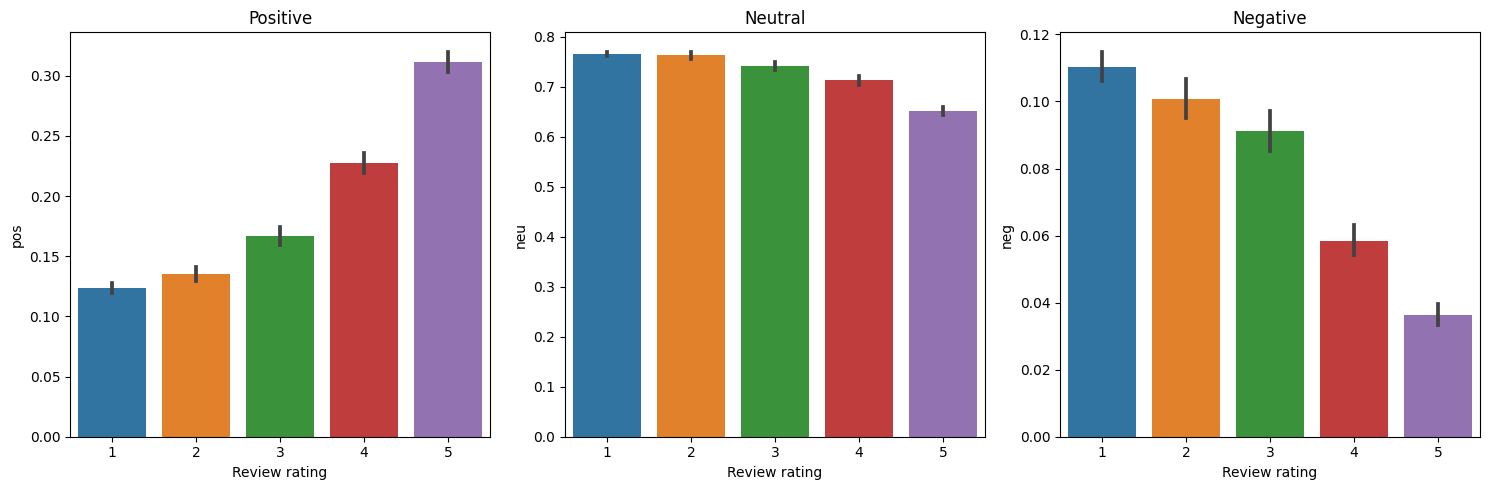

In [9]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Remarks: As expected, for ratings that are higher, they are more likely to get a higher positive score, while ratings that are lower got a higher negative score.

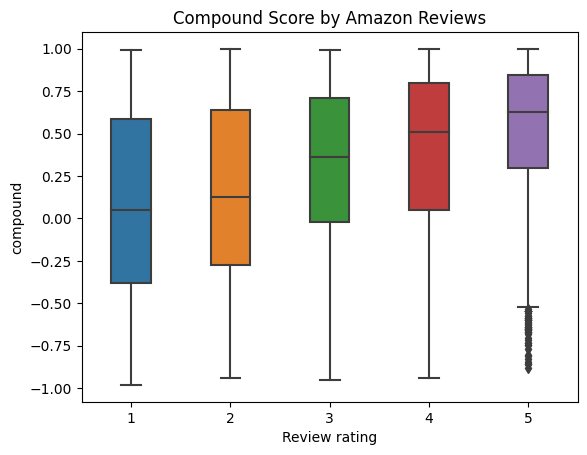

In [10]:
ax = sns.boxplot(x="Review rating", y="compound", data=vaders, width=0.4)
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

positive sentiment : (compound score >= 0.05) 

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)

As we can see, lower ratings have more negative compound scores compared to higher ratings. For the higher ratings, there are a number of negative compound scores which may suggest wrong classification by the model which we will take a closer look in the next section

## Reviewing Examples

In [11]:
vaders = vaders.rename(columns={'Review rating': 'Review_rating'})

### Checking if the model works

In [12]:
# Positive sentiment with 5-star review
vaders.query('Review_rating == 5').sort_values('pos', ascending=False)['Review Content'].values[0:10]

array(['great', 'like', 'perfect', 'perfect', 'great', 'great', 'nice',
       'nice', 'great', 'great'], dtype=object)

In [13]:
# Negative sentiment with 1-star review
vaders.query('Review_rating == 1').sort_values('neg', ascending=False)['Review Content'].values[0:10]

array(['bad', 'po', 'po', 'disgust', 'worst ever', 'absolut hate',
       'connect problem', 'continu problem', 'worst ever scam last print',
       'stop work'], dtype=object)

### Checking if the model produces inaccurate results

In [14]:
# Positive sentiment but with 1-star review
vaders.query('Review_rating == 1').sort_values('pos', ascending=False)['Review Content'].values[0:5]

array(['good', 'good buy', 'return amazon', 'pleas care product',
       'epson support product'], dtype=object)

In [15]:
# Negative sentiment but with 5-star review
vaders.query('Review_rating == 5').sort_values('neg', ascending=False)['Review Content'].values[0:5]

array(['complaint', 'difficult', 'complaint buy',
       'difficult done work weird', 'fail de instal'], dtype=object)

Some gave positive feedback but gave low ratings, while some gave negative feedback but high ratings. Might be inaccurate ratings on user's end or "troll" feedback

## Vader Sentiment Scoring on Review Content based on sentence split

#### Note: This is going to be used in conjuction with Topic Modelling, analysing the sentiments based on topics

In [16]:
# Load the Excel file into a DataFrame
df_SA_sent = pd.read_excel('amazon_review_processed_sents.xlsx')

# Creating a new Review ID column
df_SA_sent['Review ID'] = df_SA_sent['ID']
df_SA_sent['ID'] = range(0, len(df_SA_sent))

# Display the DataFrame
df_SA_sent.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,['easi instal work great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,work great,0,1
1,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,work great,['easi instal work great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,easi instal work great,1,1
2,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,"['slower speed im use old model', ' 8600 new 9...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,spunki mid size,2,2
3,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,"['slower speed im use old model', ' 8600 new 9...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,slower speed im use old model,3,2
4,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunki mid size,"['slower speed im use old model', ' 8600 new 9...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,8600 new 9015e sound like break apart insid,4,2


#### Comparing the number of reviews for each rating after splitting into sentences

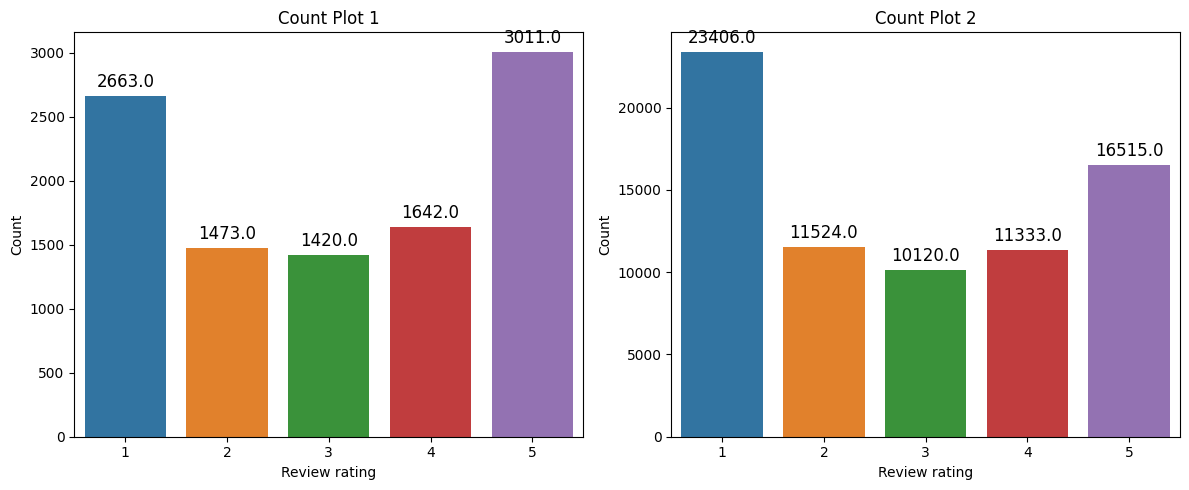

In [17]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first count plot
ax1 = sns.countplot(x="Review rating", data=df_SA, ax=axes[0])
axes[0].set_xlabel("Review rating")
axes[0].set_ylabel("Count")
axes[0].set_title("Count Plot 1")

# Add count labels on top of the bars for the first plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Plot the second count plot (can have different data or settings)
ax2 = sns.countplot(x="Review rating", data=df_SA_sent, ax=axes[1])
axes[1].set_xlabel("Review rating")
axes[1].set_ylabel("Count")
axes[1].set_title("Count Plot 2")

# Add count labels on top of the bars for the second plot
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Running the Vader Sentiment Analysis

In [18]:
# Running the polarity score on the entire dataset
res2 = {}
for i, row in tqdm(df_SA_sent.iterrows(), total=len(df_SA_sent)):
    text = row['Full review']
    myid = row['ID']
    res2[myid] = sia.polarity_scores(text)

  0%|          | 0/72898 [00:00<?, ?it/s]

In [19]:
vaders_sent = pd.DataFrame(res2).T
vaders_sent = vaders_sent.reset_index().rename(columns={'index':'ID'})
vaders_sent = vaders_sent.merge(df_SA_sent, how='left')

## Plotting VADER results on Review Content based on sentence split


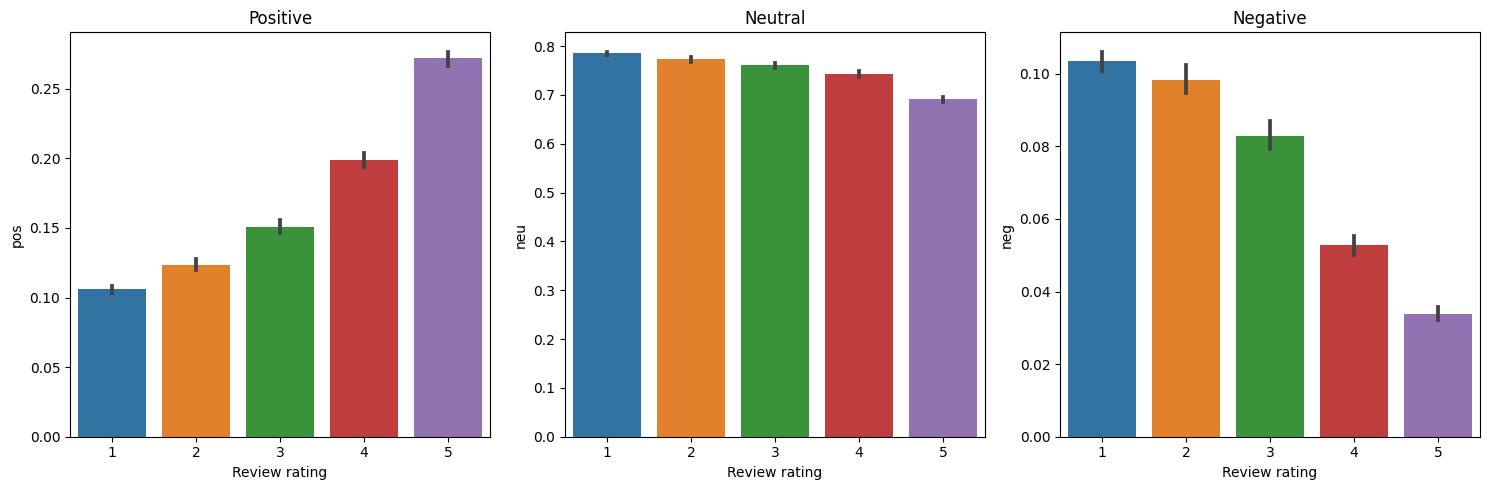

In [20]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data=vaders_sent, x='Review rating', y = 'pos', ax=axs[0])
sns.barplot(data=vaders_sent, x='Review rating', y = 'neu', ax=axs[1])
sns.barplot(data=vaders_sent, x='Review rating', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

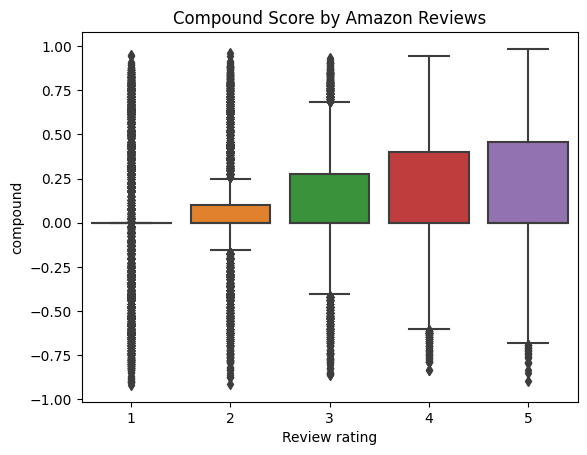

In [21]:
ax = sns.boxplot(data=vaders_sent, x='Review rating', y='compound')
ax.set_title('Compound Score by Amazon Reviews')
plt.show()

For the lower ratings, there seems to be quite a number of positive compound scores, which may suggest that certain sentences acknowledges that there are positive feedback but overall the negative outweighs the positives.

In [22]:
for rating in range(1, 6):
    # Filter the DataFrame to include only rows where "Review rating" matches the current rating
    filtered_df = vaders_sent[vaders_sent['Review rating'] == rating]

    # Create a list of words in each "Full review"
    word_lists = filtered_df['Full review'].str.split()

    # Calculate the number of words in each "Full review" and sum them up
    word_counts = word_lists.apply(len)

    # Total number of words in all "Full review" where "Review rating" matches the current rating
    total_word_count = word_counts.sum()

    print(f"Total number of words in 'Full review' for 'Review rating' == {rating}: {total_word_count}")

Total number of words in 'Full review' for 'Review rating' == 1: 138690
Total number of words in 'Full review' for 'Review rating' == 2: 65399
Total number of words in 'Full review' for 'Review rating' == 3: 59070
Total number of words in 'Full review' for 'Review rating' == 4: 64739
Total number of words in 'Full review' for 'Review rating' == 5: 84675


In [23]:
# Split the "Full review" column into words and count the number of words for each review
vaders_sent['Word Count'] = vaders_sent['Full review'].str.split().apply(len)

# Group the DataFrame by "Review rating" and find the "Full Review" with the maximum word count within each group
max_word_count_reviews = vaders_sent.groupby('Review rating', group_keys=False).apply(lambda x: x.loc[x['Word Count'].idxmax()])

# Display the result
for rating in range(1, 6):
    max_review = max_word_count_reviews[max_word_count_reviews['Review rating'] == rating]
    review_id = max_review['Review ID'].values[0]
    full_review = max_review['Full review'].values[0]
    word_count = max_review['Word Count'].values[0]
    print(f"Review rating {rating} - Review ID: {review_id}, Word Count: {word_count}\nFull Review: {full_review}\n")

Review rating 1 - Review ID: 3146, Word Count: 67
Full Review:  si una option de 0 mi la de 6 mess de tina grati es un total fraud intent de mucha form en la pagina de instar para la tina deck servic cuando servic al client te dice que pued hacer nada ni ello desd all porqu tu cent tien target de credit camera la impresora con la de que tend lo 6 mess es todo una fals

Review rating 2 - Review ID: 4108, Word Count: 47
Full Review:  okay price point shouldnt complain howev didnt find intuit cannot scan unless comput tether read app never abl app find comput turn defeat wifi wireless featur display doesnt rais hard see unless posit your easili look also bright plastic tray thin unstabl seem brittl could easili break

Review rating 3 - Review ID: 315, Word Count: 95
Full Review:  start excit know epson decent printer howev tank suck ever imagin includ took 27 piec color come put less half tank instal new bottl bad part bad part serial number complet bogu cannot regist mine there call talk

In [24]:
vaders_sent[vaders_sent['Review ID'].isin([315,3146,4108,5800,7582])]

,ID,neg,neu,pos,compound,Review Model,Retailer,Review date,Review name,Review rating,...,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,Review ID,Word Count
1790,1790,0.000,1.000,0.000,0.0000,Epson - ET-2800,Amazon,2022-08-29,Archer,3,...,1070,12,3.981395,5.500000,102,0,Epson,epson et2800,315,2
1791,1791,0.180,0.679,0.142,-0.8555,Epson - ET-2800,Amazon,2022-08-29,Archer,3,...,1070,12,3.981395,5.500000,102,0,Epson,start excit know epson decent printer howev t...,315,95
22470,22470,0.792,0.208,0.000,-0.5859,HP DeskJet 2755e,Amazon,2023-08-14,Gaby,1,...,473,12,4.386364,5.500000,8,0,HP,fraud total,3146,2
22471,22471,0.123,0.840,0.036,-0.7351,HP DeskJet 2755e,Amazon,2023-08-14,Gaby,1,...,473,12,4.386364,5.500000,8,0,HP,si una option de 0 mi la de 6 mess de tina gr...,3146,67
28511,28511,0.000,1.000,0.000,0.0000,Canon PIXMA TR4720,Amazon,2023-07-19,SomebodyOutThere,2,...,608,56,4.205128,3.750000,53,7,Canon,bought sale 50 would buy,4108,5
28512,28512,0.056,0.789,0.154,0.4949,Canon PIXMA TR4720,Amazon,2023-07-19,SomebodyOutThere,2,...,608,56,4.205128,3.750000,53,7,Canon,okay price point shouldnt complain howev didn...,4108,47
28513,28513,0.000,1.000,0.000,0.0000,Canon PIXMA TR4720,Amazon,2023-07-19,SomebodyOutThere,2,...,608,56,4.205128,3.750000,53,7,Canon,would buy base upon need,4108,5
39894,39894,0.000,1.000,0.000,0.0000,HP OfficeJet Pro 9025e,Amazon,2022-09-01,Sl,4,...,1919,41,4.865031,5.000000,108,0,HP,officejet pro 9025e is epson et15000,5800,6
39895,39895,0.000,1.000,0.000,0.0000,HP OfficeJet Pro 9025e,Amazon,2022-09-01,Sl,4,...,1919,41,4.865031,5.000000,108,0,HP,ive custom long time,5800,4
39896,39896,0.000,1.000,0.000,0.0000,HP OfficeJet Pro 9025e,Amazon,2022-09-01,Sl,4,...,1919,41,4.865031,5.000000,108,0,HP,enough highpric cartridg purchas highli rate ...,5800,9


## Reviewing Examples

In [26]:
vaders_sent = vaders_sent.rename(columns={'Review rating': 'Review_rating'})

### Checking if the model works after splitting into sentence

In [27]:
# Positive sentiment with 5-star review
vaders_sent.query('Review_rating == 5').sort_values('pos', ascending=False)['Full review'].values[0]

'great'

In [28]:
# Negative sentiment with 1-star review
vaders_sent.query('Review_rating == 1').sort_values('neg', ascending=False)['Full review'].values[0]

' disappoint'

### Checking if the model produces inaccurate results

In [74]:
# Positive sentiment but with 1-star review
vaders_sent.query('Review_rating == 1').sort_values('pos', ascending=False)['Original review'].values[0:5]

array(['The printer itself is a the perfect size for your home office/desk. The liquid ink is so much cheaper than cartridges, extremely easy to use and much cheaper. The app is user friendly and I love being able to print/scan from my phone. Setup was super easy and quick.The printer gets an A for the printing function. Prints quickly, no smears or smudges and the paper feeds straight. The printing quality is great.The scan function? Not so much. The very first time I tried to scan, it was a 7 page document so I used the automatic document feeder. It would’t suck the paper down, had zero pull. I opened the lid and pushed the paper down further so it would catch. It then pulled 4 sheets, cattywampus, then jammed. I opened the lid to remove the jam and there was a white plastic piece floating free, it was broken. FIRST USE. I still needed to scan so I used the scanner glass and did all 7 pages individually. It was much darker than what a normal white document should look like, so much s

Some reviews may mention positive things but ended the review with negative points. Or they could be sarcastic which may not be detected by the Vader model.

In [30]:
# Negative sentiment but with 5-star review
vaders_sent.query('Review_rating == 5').sort_values('neg', ascending=False)['Original review'].values[0:5]

array(['Facil de instalar',
       'It was hard to link it to my desk top. No phone number to call for any tech support. Had to have a friend who is a computer tech for another company link it to my computer.',
       'I could not figure out how to connect this printer to the wifi. Turns out I had an outdated software.  Once I called them, they got things going and the printer works perfectly. Do yourself a favor and call HP',
       'This is a great printer for home or small business use.  HOWEVER, Epson ink is expensive.  If you use compatible ink not manufactured by Epson, do not ever install a firmware update.  If you do, the printer will no longer recognize your ink.  US Courts ruled some time back that printers could not refuse to use replacement ink that was not from the printer manufacturer.  However, Epson still sends out "firmware updates" and after those updates your printer will not recognize non-Epson manufactured ink.  If you only use Epson-manufactured ink.  there is no 

Some of the reviews are strictly negative but the ratings show otherwise. It could be an error from the customer end where the misclicked.
There are also reviews where customers bought Brand A, but mentioned bad points about Brand B in comparison to Brand A thus the model labels it as negative overall.

# Sentiment Analaysis based on Topics

In [31]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator

In [32]:
# Load the Excel file into a DataFrame
df_TM_sent = pd.read_excel('amazon_review_processed_sents_v2.xlsx')

# Creating a new Review ID column
df_TM_sent['Review ID'] = df_TM_sent['ID']
df_TM_sent['ID'] = range(0, len(df_TM_sent))

# Display the DataFrame
df_TM_sent.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_char_count,title_char_count,content_avg_word,title_avg_word,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,works great,0,1
1,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,38,11,3.875000,5.0,3,0,Canon,easy install works great,1,1
2,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,spunky mid size,2,2
3,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,slower speed im used old model,3,2
4,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,460,23,4.835443,5.0,19,0,HP,8600 new 9015e sounds like breaking apart inside,4,2


In [33]:
# Tokenisation (Review Content)
df_TM_sent['Tokenized Content'] = df_TM_sent['Review Content'].apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else [])
df_TM_sent[['Review Content', 'Tokenized Content']].head(5)

,Review Content,Tokenized Content
0,['easy install works great'],"[[, 'easy, install, works, great, ', ]]"
1,['easy install works great'],"[[, 'easy, install, works, great, ', ]]"
2,"['slower speed im used old model', ' 8600 new ...","[[, 'slower, speed, im, used, old, model, ', ,..."
3,"['slower speed im used old model', ' 8600 new ...","[[, 'slower, speed, im, used, old, model, ', ,..."
4,"['slower speed im used old model', ' 8600 new ...","[[, 'slower, speed, im, used, old, model, ', ,..."


In [34]:
non_word_pattern = re.compile(r'[^a-zA-Z ]')

# Use a list comprehension to remove non-word characters from each list
df_TM_sent['Tokenized Content'] = [[word for word in non_word_pattern.sub('', ' '.join(item)).split()] for item in df_TM_sent['Tokenized Content']]
df_TM_sent[['Review Content', 'Tokenized Content']].head(5)

,Review Content,Tokenized Content
0,['easy install works great'],"[easy, install, works, great]"
1,['easy install works great'],"[easy, install, works, great]"
2,"['slower speed im used old model', ' 8600 new ...","[slower, speed, im, used, old, model, new, e, ..."
3,"['slower speed im used old model', ' 8600 new ...","[slower, speed, im, used, old, model, new, e, ..."
4,"['slower speed im used old model', ' 8600 new ...","[slower, speed, im, used, old, model, new, e, ..."


In [35]:
def perform_topic_modelling (df):
    # Create a dictionary from the tokenized content
    dictionary = corpora.Dictionary(df['Tokenized Content'])

    # Create a corpus (bag of words) from the tokenized content
    corpus = [dictionary.doc2bow(text) for text in df['Tokenized Content']]

    # Build the LDA model
    num_topics = 10  # You can adjust the number of topics as needed
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

    # Print the topics and their top words
    topics = lda_model.print_topics(num_words=10)
    # for topic in topics:
    #     print(topic)

    # Assign the dominant topic to each document
    # filtered_df['Dominant Topic'] = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

    # Extract top words from topics
    top_words = []
    for i in range(num_topics):
        top_words.extend(re.findall(r"[a-z]+", lda_model.print_topic(i, topn=5)))

    # Join the top words into a single string
    top_words = " ".join(top_words)
    # print(top_words)

    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(top_words)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

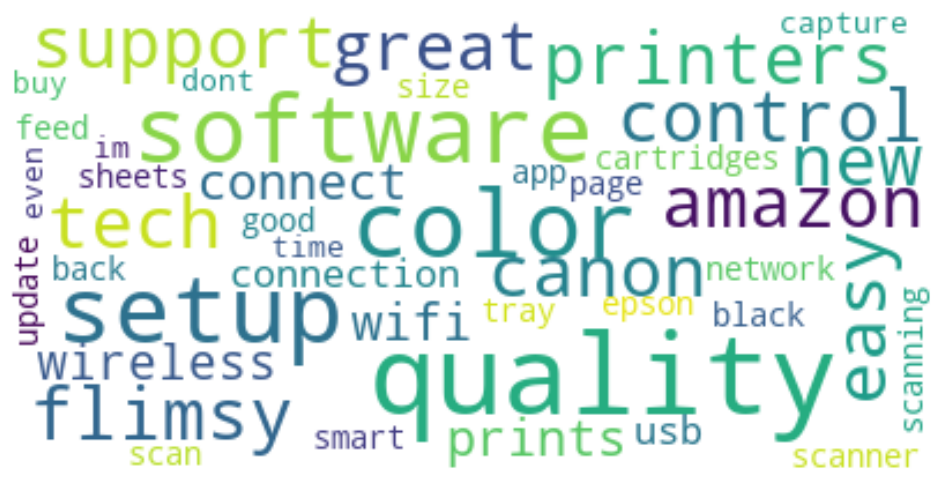

In [36]:
perform_topic_modelling(df_TM_sent)

In [37]:
# Create a dictionary from the tokenized content
dictionary = corpora.Dictionary(df_TM_sent['Tokenized Content'])

# Create a corpus (bag of words) from the tokenized content
corpus = [dictionary.doc2bow(text) for text in df_TM_sent['Tokenized Content']]

# Build the LDA model
num_topics = 6  
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

In [38]:
# Print the topics and their top words
topics = lda_model.show_topics(6,10)

for i in range(0, 6):
    print(f"Topic {i + 1}: {lda_model.print_topic(i)}")

Topic 1: 0.026*"epson" + 0.017*"scanning" + 0.016*"scan" + 0.015*"scanner" + 0.012*"color" + 0.011*"printers" + 0.008*"feature" + 0.008*"cartridges" + 0.007*"black" + 0.007*"e"
Topic 2: 0.018*"support" + 0.016*"would" + 0.011*"new" + 0.011*"tech" + 0.010*"back" + 0.009*"bought" + 0.008*"problem" + 0.008*"amazon" + 0.008*"could" + 0.008*"customer"
Topic 3: 0.020*"quality" + 0.019*"easy" + 0.013*"good" + 0.012*"great" + 0.012*"like" + 0.010*"prints" + 0.009*"photo" + 0.008*"tray" + 0.008*"well" + 0.008*"old"
Topic 4: 0.024*"software" + 0.022*"smart" + 0.021*"wifi" + 0.021*"scan" + 0.021*"app" + 0.016*"connect" + 0.015*"computer" + 0.014*"network" + 0.013*"setup" + 0.011*"wireless"
Topic 5: 0.022*"cartridges" + 0.018*"dont" + 0.015*"pages" + 0.013*"instant" + 0.012*"plan" + 0.012*"cartridge" + 0.011*"month" + 0.011*"free" + 0.010*"need" + 0.010*"months"
Topic 6: 0.020*"time" + 0.010*"page" + 0.009*"every" + 0.009*"back" + 0.009*"even" + 0.008*"ive" + 0.008*"im" + 0.008*"printed" + 0.008*"

Based on the above, we can categorise the 6 topics as follows:

Topic 1: Scanning function

Topic 2: Customer support

Topic 3: Quality

Topic 4: Software

Topic 5: Catridges

Topic 6: Others

In [39]:
# Initialize an empty list to store the dominant topics
dominant_topics = []

# Loop through the documents and get the dominant topic for each
for text in df_TM_sent['Tokenized Content']:
    # Get the dominant topic for the document
    topics = lda_model.get_document_topics(dictionary.doc2bow(text))
    
    # Sort the topics by the proportion and get the most dominant one
    dominant_topic = max(topics, key=lambda x: x[1])
    
    # Append the dominant topic to the list
    dominant_topics.append(dominant_topic[0])

# Create a new column in the DataFrame to store the dominant topics
df_TM_sent['Dominant Topic ID'] = dominant_topics

In [40]:
# Define a mapping dictionary
topic_mapping = {
    0: "Scanning function",
    1: "Customer support",
    2: "Quality",
    3: "Software",
    4: "Cartridges",
    5: "Others"
}

# Map the dominant topic IDs to their corresponding topics and store the result in a new column
df_TM_sent['Topic'] = df_TM_sent['Dominant Topic ID'].map(topic_mapping)

## Visualizing the sentiments by Topic

In [41]:
# Combining compound score with the topics into a new dataframe
df_combined = df_TM_sent.merge(vaders_sent[['ID', 'compound']], on='ID', how='inner')

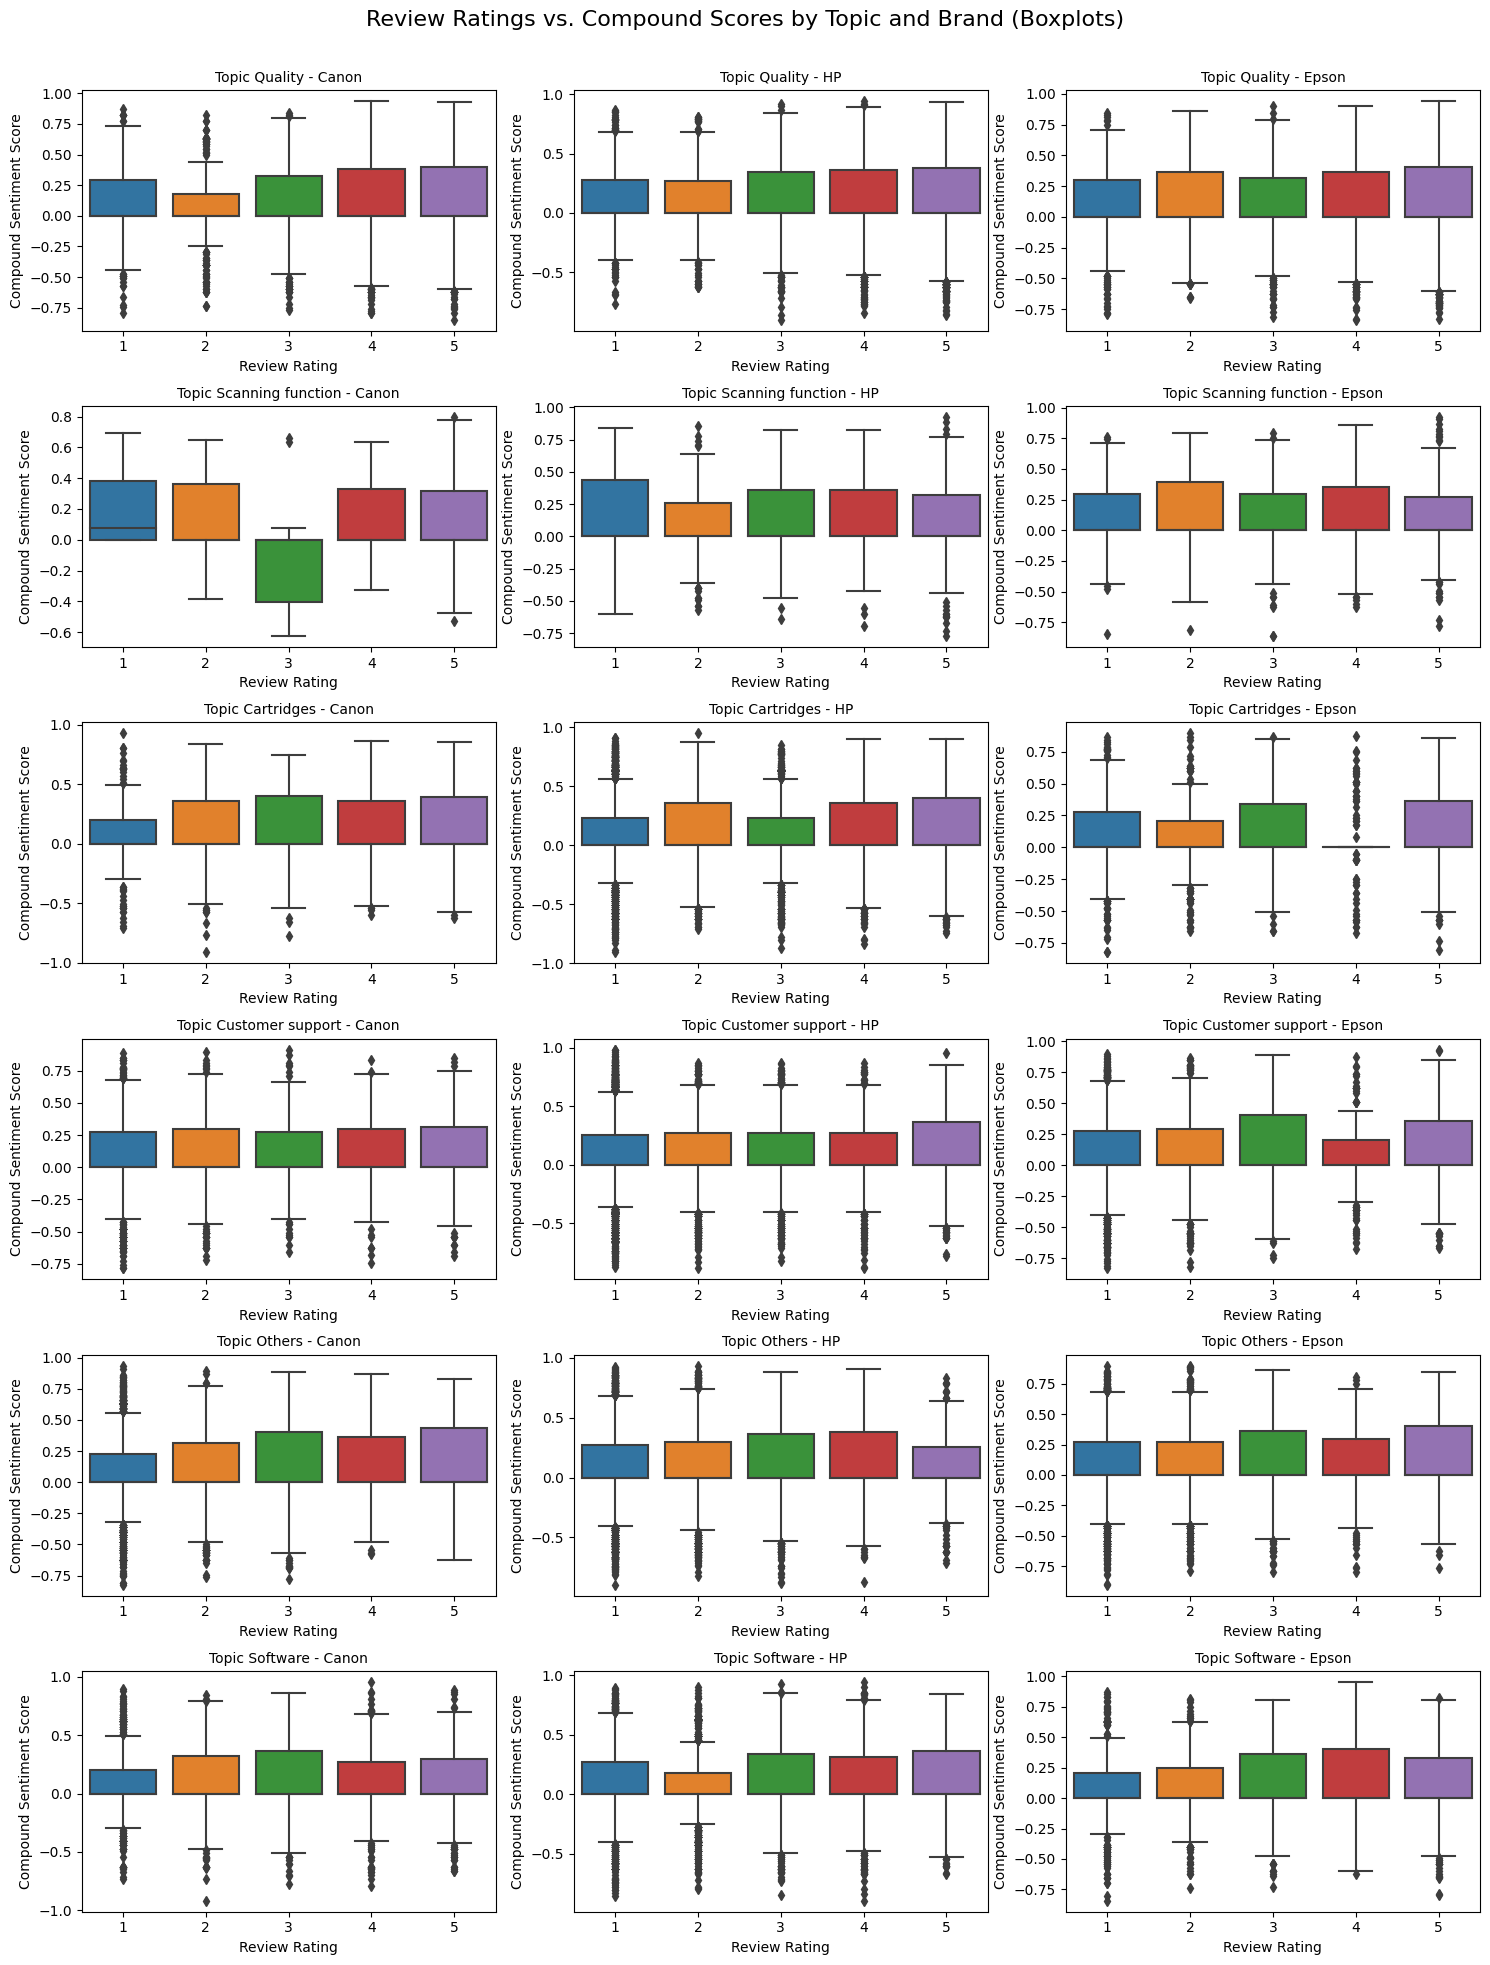

In [58]:
# Create a figure with 6 subplots for each topic and 3 columns for each brand
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle("Review Ratings vs. Compound Scores by Topic and Brand (Boxplots)", fontsize=16)

# Using Seaborn
topics = df_combined['Topic'].unique()
brands = df_combined['Brand'].unique()

for i, topic in enumerate(topics):
    for j, brand in enumerate(brands):
        # Select data for the current topic and brand
        topic_brand_data = df_combined[(df_combined['Topic'] == topic) & (df_combined['Brand'] == brand)]
        
        # Create a box plot for review ratings vs. compound scores
        sns.boxplot(x='Review rating', y='compound', data=topic_brand_data, ax=axes[i, j])
        axes[i, j].set_title(f'Topic {topic} - {brand}', fontsize=10)
        axes[i, j].set_xlabel('Review Rating')
        axes[i, j].set_ylabel('Compound Sentiment Score')

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

In [67]:
filtered_df = df_combined[(df_combined['Brand'] == 'Canon') & (df_combined['Topic'] == 'Scanning function') & (df_combined['compound'] < 0) & (df_combined['Review rating'] == 3)]
filtered_df.head(5)
filtered_df['compound'].mean()

-0.38520000000000004

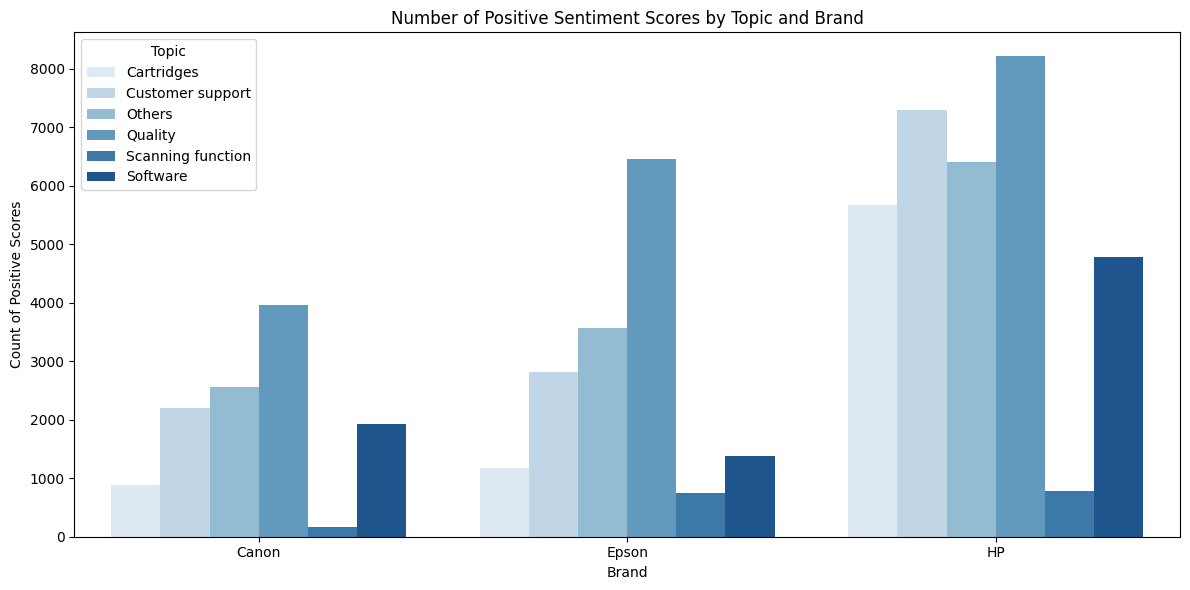

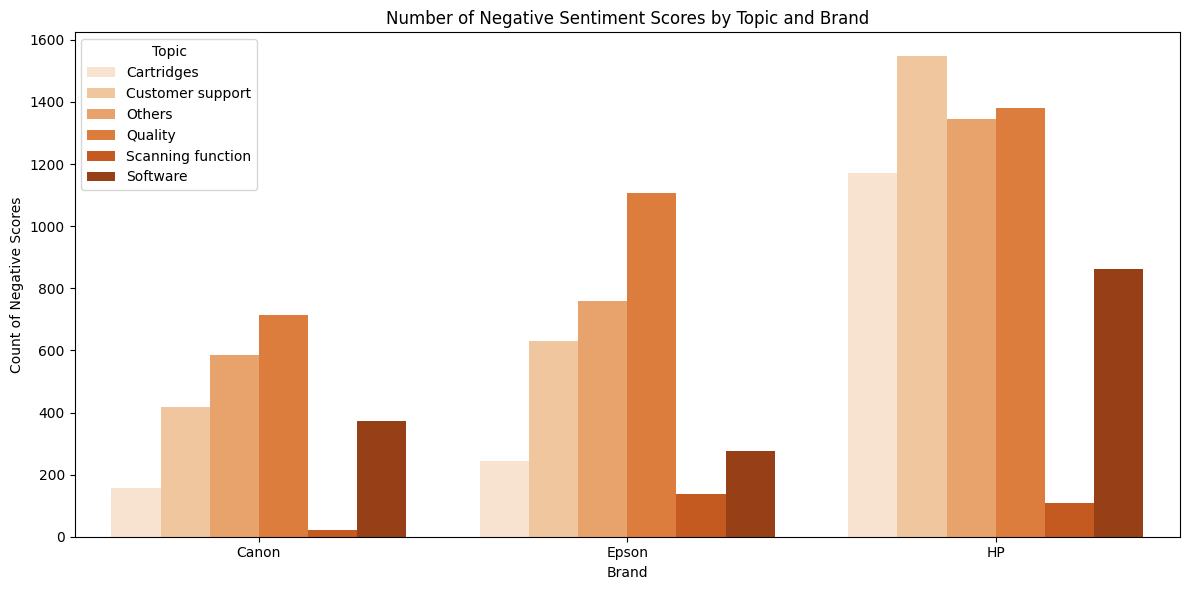

In [43]:
# Calculate the number of positive and negative compound scores for each topic by brand
count_data = df_combined.groupby(['Topic', 'Brand'])['compound'].apply(lambda x: pd.Series({'Count_Positive': (x >= 0).sum(), 'Count_Negative': (x < 0).sum()})).unstack(fill_value=0)

# Reset the index
count_data = count_data.reset_index()

# Plot the counts of positive scores in a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Brand', y='Count_Positive', hue='Topic', data=count_data, palette='Blues')
plt.xlabel('Brand')
plt.ylabel('Count of Positive Scores')
plt.title('Number of Positive Sentiment Scores by Topic and Brand')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

# Plot the counts of negative scores in a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Brand', y='Count_Negative', hue='Topic', data=count_data, palette='Oranges')
plt.xlabel('Brand')
plt.ylabel('Count of Negative Scores')
plt.title('Number of Negative Sentiment Scores by Topic and Brand')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

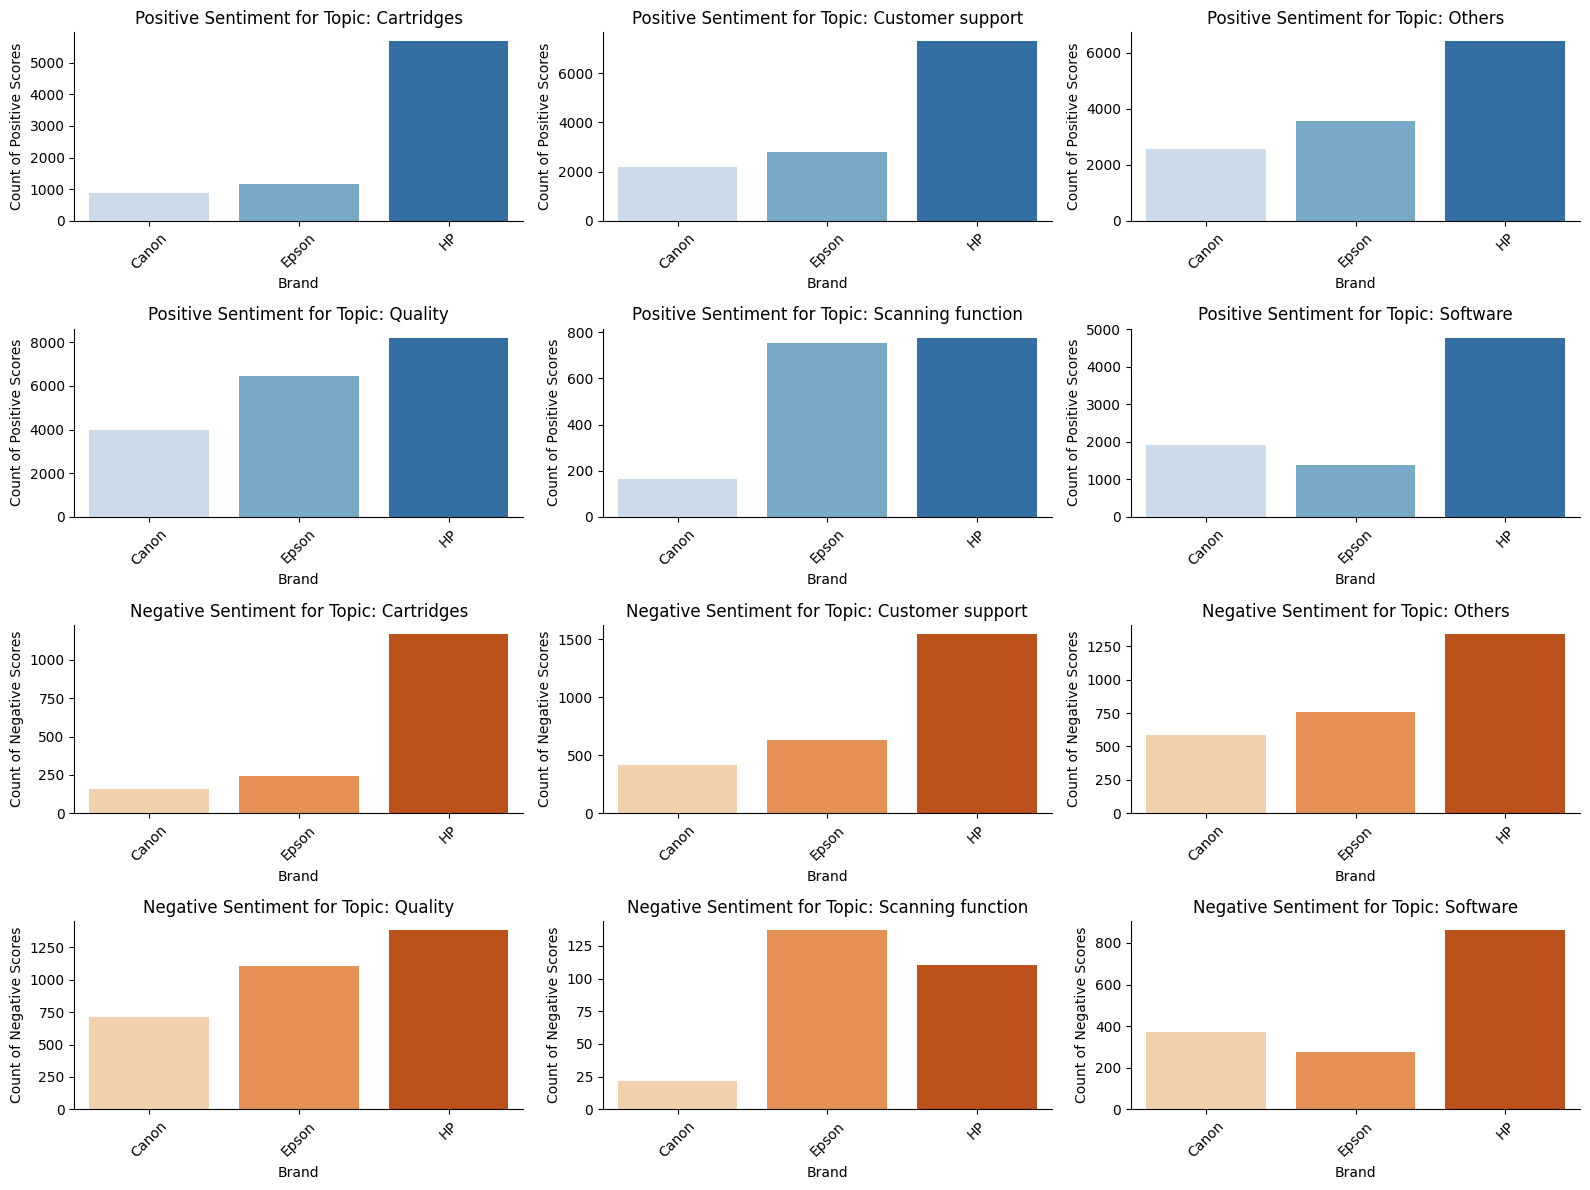

In [44]:
# Calculate the number of positive and negative compound scores for each topic by brand
count_data = df_combined.groupby(['Topic', 'Brand'])['compound'].apply(lambda x: pd.Series({'Count_Positive': (x >= 0).sum(), 'Count_Negative': (x < 0).sum()})).unstack(fill_value=0)

# Reset the index
count_data = count_data.reset_index()

# Get unique topics
topics = count_data['Topic'].unique()

# Set up a 4 x 3 grid for the subplots
fig, axes = plt.subplots(4, 3, figsize=(16, 12))

# Create separate bar charts for each topic and positive sentiment
for i, topic in enumerate(topics):
    topic_data = count_data[count_data['Topic'] == topic]
    row, col = divmod(i, 3)

    # Positive sentiment
    sns.barplot(x='Brand', y='Count_Positive', data=topic_data, palette='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'Positive Sentiment for Topic: {topic}')
    axes[row, col].set_xlabel('Brand')
    axes[row, col].set_ylabel('Count of Positive Scores')
    axes[row, col].tick_params(axis='x', rotation=45)
    sns.despine(ax=axes[row, col])

    # Negative sentiment
    sns.barplot(x='Brand', y='Count_Negative', data=topic_data, palette='Oranges', ax=axes[row + 2, col])
    axes[row + 2, col].set_title(f'Negative Sentiment for Topic: {topic}')
    axes[row + 2, col].set_xlabel('Brand')
    axes[row + 2, col].set_ylabel('Count of Negative Scores')
    axes[row + 2, col].tick_params(axis='x', rotation=45)
    sns.despine(ax=axes[row + 2, col])

plt.tight_layout()
plt.show()

In [57]:
df_combined[df_combined['Topic'] == 'Customer support'].head(10)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID,Tokenized Content,Dominant Topic ID,Topic,compound
14,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,user friendly,14,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000
15,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,would think something simple reconnecting wif...,15,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000
16,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,nope,16,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000
17,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,first reset wifi let sit two hours,17,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000
18,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,seriously,18,5,"[would, think, something, simple, reconnecting...",1,Customer support,-0.0772
19,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,different directions said restart router comp...,19,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000
20,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,directions support super confusing,20,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.7650
21,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,also ambiguous language specify things someon...,21,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0258
22,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,always option call someone would prefer troub...,22,5,"[would, think, something, simple, reconnecting...",1,Customer support,-0.3400
23,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,user friendly,['would think something simple reconnecting wi...,True,0.0,False,...,71,0,HP,also noticed lot pages issues three pages,23,5,"[would, think, something, simple, reconnecting...",1,Customer support,0.0000


In [55]:
df_combined[df_combined['Topic'] == 'Quality'].head(10)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID,Tokenized Content,Dominant Topic ID,Topic,compound
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,3,0,Canon,works great,0,1,"[easy, install, works, great]",2,Quality,0.6249
1,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,works great,['easy install works great'],True,0.0,False,...,3,0,Canon,easy install works great,1,1,"[easy, install, works, great]",2,Quality,0.6249
2,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,19,0,HP,spunky mid size,2,2,"[slower, speed, im, used, old, model, new, e, ...",2,Quality,0.0000
3,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,19,0,HP,slower speed im used old model,3,2,"[slower, speed, im, used, old, model, new, e, ...",2,Quality,0.0000
4,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,19,0,HP,8600 new 9015e sounds like breaking apart inside,4,2,"[slower, speed, im, used, old, model, new, e, ...",2,Quality,0.3612
5,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size,"['slower speed im used old model', ' 8600 new ...",True,0.0,False,...,19,0,HP,setup annoyingly complex luckily researched w...,5,2,"[slower, speed, im, used, old, model, new, e, ...",2,Quality,0.8348
197,HP DeskJet 4155e,Amazon,2023-06-28,JoJo,5,excellent buy,"['cant go wrong', ' least opinion', ' thank gr...",True,0.0,False,...,8,0,HP,excellent buy,197,30,"[cant, go, wrong, least, opinion, thank, great...",2,Quality,0.0000
198,HP DeskJet 4155e,Amazon,2023-06-28,JoJo,5,excellent buy,"['cant go wrong', ' least opinion', ' thank gr...",True,0.0,False,...,8,0,HP,cant go wrong,198,30,"[cant, go, wrong, least, opinion, thank, great...",2,Quality,0.4588
199,HP DeskJet 4155e,Amazon,2023-06-28,JoJo,5,excellent buy,"['cant go wrong', ' least opinion', ' thank gr...",True,0.0,False,...,8,0,HP,least opinion,199,30,"[cant, go, wrong, least, opinion, thank, great...",2,Quality,0.3724
200,HP DeskJet 4155e,Amazon,2023-06-28,JoJo,5,excellent buy,"['cant go wrong', ' least opinion', ' thank gr...",True,0.0,False,...,8,0,HP,thank great product,200,30,"[cant, go, wrong, least, opinion, thank, great...",2,Quality,0.0000


In [56]:
df_combined[df_combined['Topic'] == 'Cartridges'].head(10)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,...,content_stopwords,title_stopwords,Brand,Full review,ID,Review ID,Tokenized Content,Dominant Topic ID,Topic,compound
7,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,shaq knows hes talking,7,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,0.0000
8,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,yup slam,8,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,-0.3818
9,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,upgrade,9,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,0.0000
10,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,paid little front equivalent throw away types...,10,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,0.4939
11,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,longer trying find absolute lowest possible u...,11,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,-0.3818
12,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,macbooks iphone ipad easy breezy,12,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,0.0000
13,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,shaq knows hes talking,"['yup slam', ' upgrade', ' paid little front e...",True,12.0,False,...,31,2,Epson,theyve done great job engineering filling pro...,13,4,"[yup, slam, upgrade, paid, little, front, equi...",4,Cartridges,0.7096
45,Epson - ET-2800,Amazon,2023-02-24,Justin,3,difficult,['need masters engineering thing'],True,2.0,False,...,4,1,Epson,difficult,45,12,"[need, masters, engineering, thing]",4,Cartridges,0.2263
46,Epson - ET-2800,Amazon,2023-02-24,Justin,3,difficult,['need masters engineering thing'],True,2.0,False,...,4,1,Epson,need masters engineering thing,46,12,"[need, masters, engineering, thing]",4,Cartridges,-0.3612
64,HP ENVY Inspire 7955e,Amazon,2023-07-02,Sstocker,2,complicated,"['must download app', ' ok fine', ' needed ano...",True,0.0,False,...,52,0,HP,complicated,64,15,"[must, download, app, ok, fine, needed, anothe...",4,Cartridges,0.0000
